In [9]:
!pip install pandas numpy matplotlib seaborn scipy

Error processing line 1 of /Users/romanticd/anaconda3/envs/tf_env/lib/python3.10/site-packages/distutils-precedence.pth:

  Traceback (most recent call last):
    File "/Users/romanticd/anaconda3/envs/tf_env/lib/python3.10/site.py", line 195, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
  ModuleNotFoundError: No module named '_distutils_hack'

Remainder of file ignored

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


### Exploratory Data Analysis

Data source: AirQualityUCI.csv
DATASET OVERVIEW
Shape: (9471, 15)

Columns: ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

Data types:
Date              object
Time              object
CO(GT)           float64
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)         float64
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                float64
RH               float64
AH               float64
dtype: object

Temporal range: 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Duration: 389 days

MISSING VALUE ANALYSIS
               Count  Percentage
NMHC(GT)        8443       90.23
CO(GT)          1683       17.99
NO2(GT)         1642       17.55
NOx(GT)         1639       17.52
PT08.S1(CO)      366        3.91
C6H6(GT)         366        3.91
PT08.S2(NMHC)    36

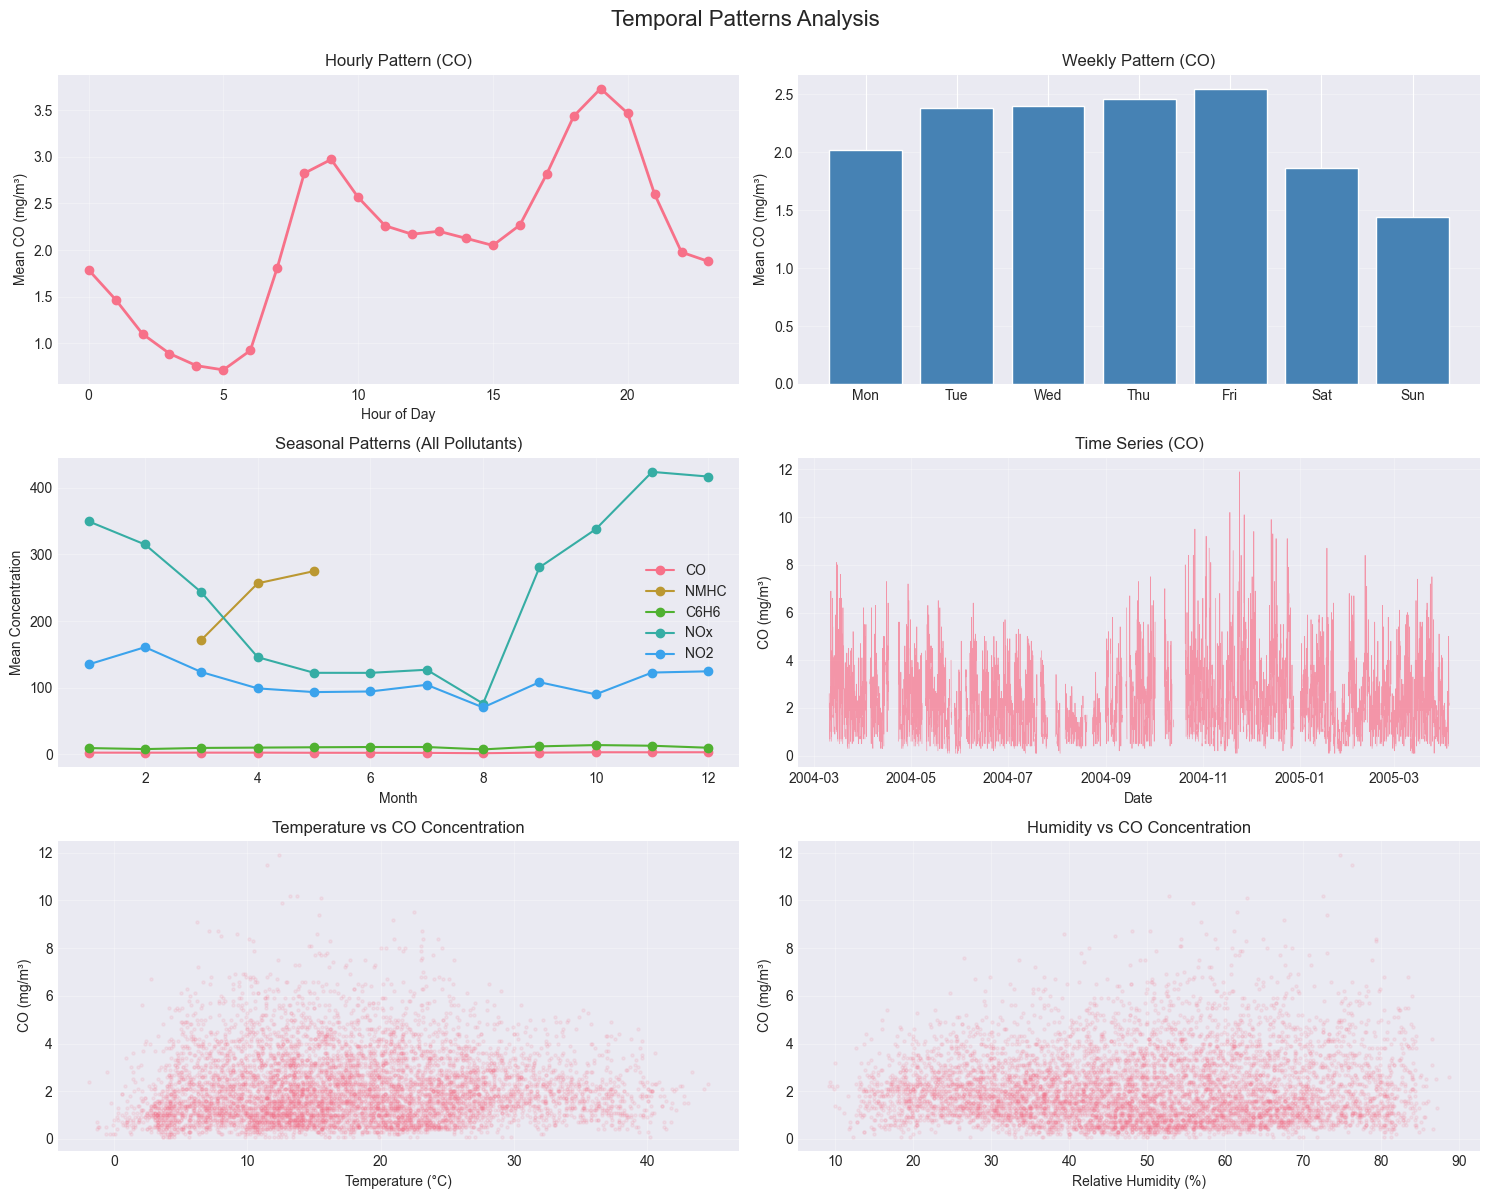

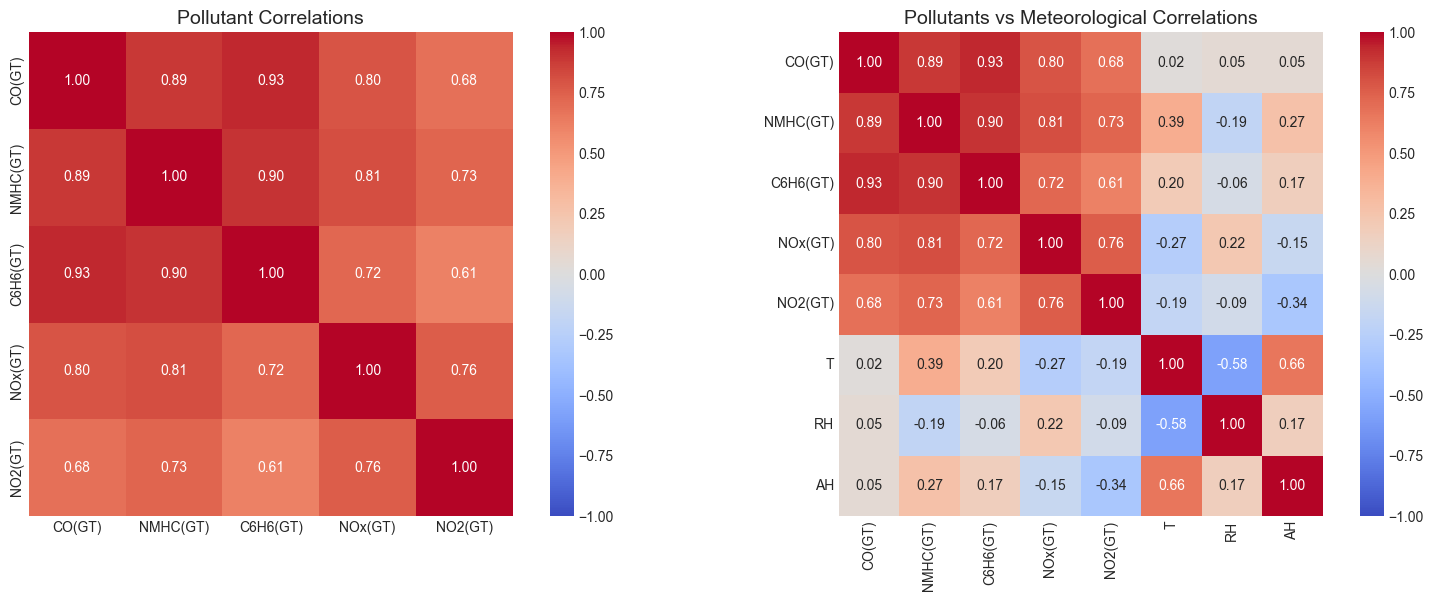

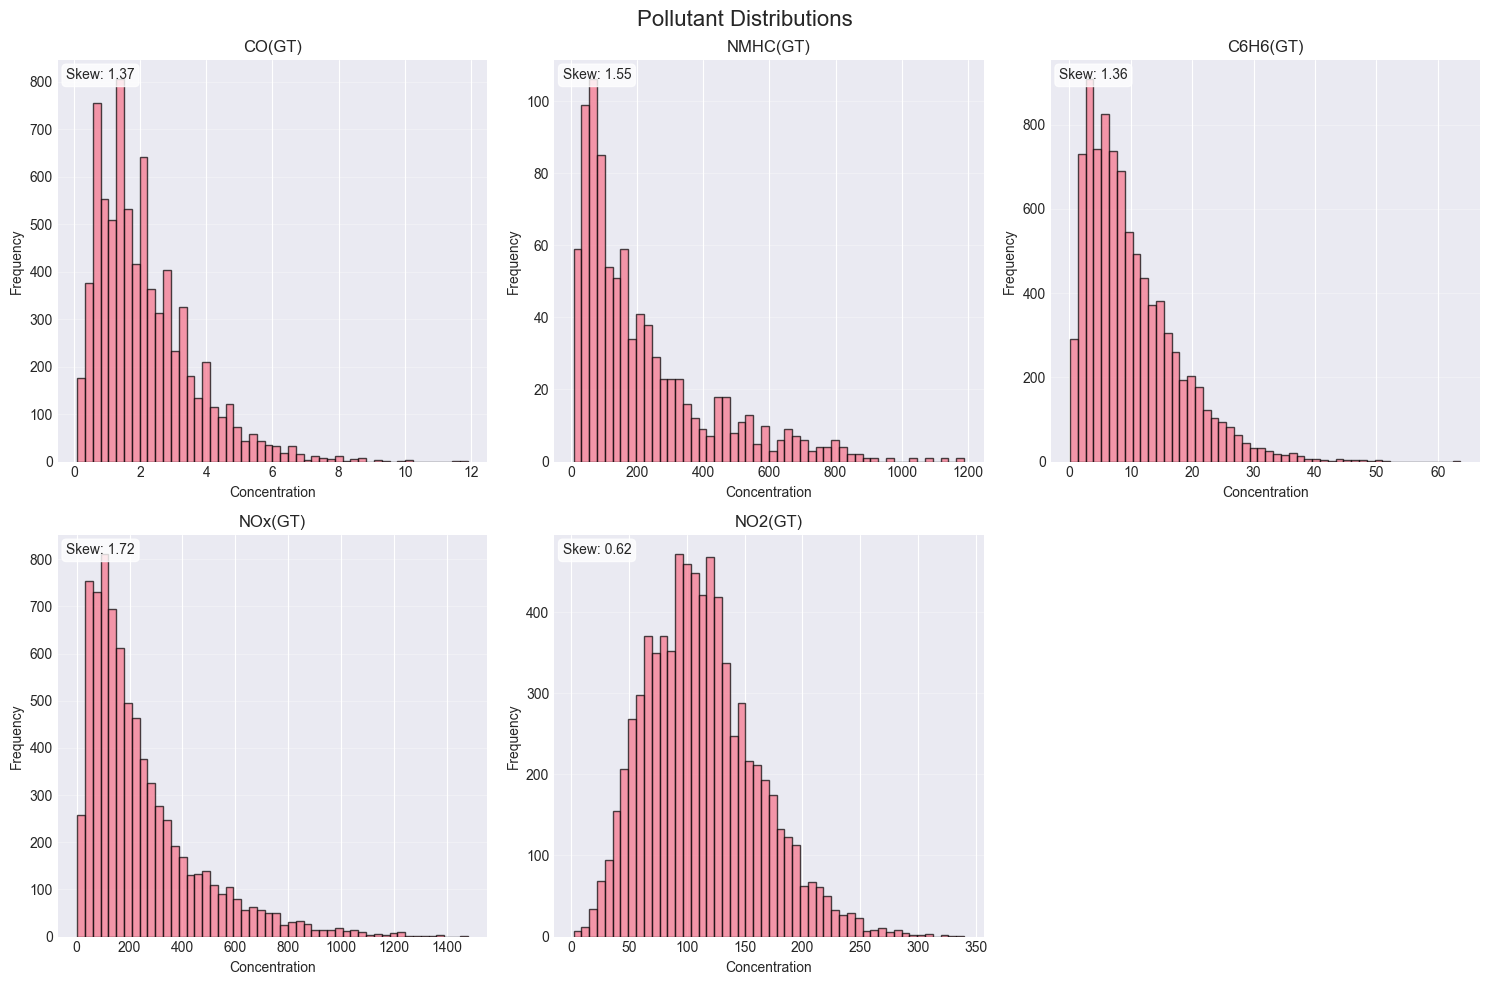

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create output directory for figures
output_dir = 'eda_figures'
os.makedirs(output_dir, exist_ok=True)

# Load data
# Try XLSX first (cleaner), fallback to CSV
try:
    df = pd.read_excel('data/air+quality/AirQualityUCI.xlsx')
    print("Data source: AirQualityUCI.xlsx")
except:
    df = pd.read_csv('data/air+quality/AirQualityUCI.csv', sep=';', decimal=',')
    print("Data source: AirQualityUCI.csv")

# Remove unnamed/empty columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# ============================================
# 1. INITIAL DATA INSPECTION
# ============================================
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")

# ============================================
# 2. TEMPORAL PREPROCESSING
# ============================================
# Merge Date and Time into unified timestamp
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'],
                                 format='%d/%m/%Y %H.%M.%S',
                                 errors='coerce')
df = df.dropna(subset=['DateTime'])
df = df.set_index('DateTime').sort_index()
df = df.drop(['Date', 'Time'], axis=1)

# Extract temporal features
df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['Year'] = df.index.year

print(f"\nTemporal range: {df.index.min()} to {df.index.max()}")
print(f"Duration: {(df.index.max() - df.index.min()).days} days")

# ============================================
# 3. MISSING VALUE ANALYSIS
# ============================================
# Replace sentinel value -200 with NaN
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    df[col] = df[col].replace(-200.0, np.nan)

print("\n" + "="*60)
print("MISSING VALUE ANALYSIS")
print("="*60)
missing_summary = pd.DataFrame({
    'Count': df.isnull().sum(),
    'Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_summary = missing_summary[missing_summary['Count'] > 0].sort_values('Count', ascending=False)
print(missing_summary)

# ============================================
# 4. DESCRIPTIVE STATISTICS
# ============================================
pollutants = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
sensors = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
meteo = ['T', 'RH', 'AH']

print("\n" + "="*60)
print("POLLUTANT STATISTICS")
print("="*60)
print(df[pollutants].describe().round(3))

# ============================================
# 5. TEMPORAL PATTERNS
# ============================================
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Temporal Patterns Analysis', fontsize=16, y=0.995)

# Hourly pattern
hourly_mean = df.groupby('Hour')['CO(GT)'].mean()
axes[0, 0].plot(hourly_mean.index, hourly_mean.values, marker='o', linewidth=2)
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Mean CO (mg/m³)')
axes[0, 0].set_title('Hourly Pattern (CO)')
axes[0, 0].grid(True, alpha=0.3)

# Weekly pattern
weekly_mean = df.groupby('DayOfWeek')['CO(GT)'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0, 1].bar(range(7), weekly_mean.values, color='steelblue')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(days)
axes[0, 1].set_ylabel('Mean CO (mg/m³)')
axes[0, 1].set_title('Weekly Pattern (CO)')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Monthly pattern for all pollutants
for i, pollutant in enumerate(pollutants):
    monthly_mean = df.groupby('Month')[pollutant].mean()
    if i == 0:
        axes[1, 0].plot(monthly_mean.index, monthly_mean.values, marker='o', label=pollutant.split('(')[0])
    else:
        axes[1, 0].plot(monthly_mean.index, monthly_mean.values, marker='o', label=pollutant.split('(')[0])
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Mean Concentration')
axes[1, 0].set_title('Seasonal Patterns (All Pollutants)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Time series plot
axes[1, 1].plot(df.index, df['CO(GT)'], linewidth=0.5, alpha=0.7)
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('CO (mg/m³)')
axes[1, 1].set_title('Time Series (CO)')
axes[1, 1].grid(True, alpha=0.3)

# Temperature vs CO
axes[2, 0].scatter(df['T'], df['CO(GT)'], alpha=0.1, s=5)
axes[2, 0].set_xlabel('Temperature (°C)')
axes[2, 0].set_ylabel('CO (mg/m³)')
axes[2, 0].set_title('Temperature vs CO Concentration')
axes[2, 0].grid(True, alpha=0.3)

# Humidity vs CO
axes[2, 1].scatter(df['RH'], df['CO(GT)'], alpha=0.1, s=5)
axes[2, 1].set_xlabel('Relative Humidity (%)')
axes[2, 1].set_ylabel('CO (mg/m³)')
axes[2, 1].set_title('Humidity vs CO Concentration')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'temporal_patterns.png'), dpi=300, bbox_inches='tight')
print(f"\n[SAVED] {output_dir}/temporal_patterns.png")

# ============================================
# 6. CORRELATION ANALYSIS
# ============================================
print("\n" + "="*60)
print("CORRELATION ANALYSIS")
print("="*60)

# Pollutant correlations
pollutant_corr = df[pollutants].corr()
print("\nPollutant Intercorrelations:")
print(pollutant_corr.round(3))

# Sensor vs Reference correlations
print("\nSensor-Reference Correlations:")
sensor_pairs = [
    ('PT08.S1(CO)', 'CO(GT)'),
    ('PT08.S2(NMHC)', 'NMHC(GT)'),
    ('PT08.S3(NOx)', 'NOx(GT)'),
    ('PT08.S4(NO2)', 'NO2(GT)')
]
for sensor, reference in sensor_pairs:
    corr = df[[sensor, reference]].corr().iloc[0, 1]
    print(f"{sensor} <-> {reference}: {corr:.3f}")

# Correlation heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pollutants correlation
sns.heatmap(pollutant_corr, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1, square=True, ax=axes[0])
axes[0].set_title('Pollutant Correlations', fontsize=14)

# Full correlation (selected features)
selected_features = pollutants + meteo
full_corr = df[selected_features].corr()
sns.heatmap(full_corr, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1, square=True, ax=axes[1])
axes[1].set_title('Pollutants vs Meteorological Correlations', fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'correlation_heatmap.png'), dpi=300, bbox_inches='tight')
print(f"\n[SAVED] {output_dir}/correlation_heatmap.png")

# ============================================
# 7. DISTRIBUTION ANALYSIS
# ============================================
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Pollutant Distributions', fontsize=16)

for idx, pollutant in enumerate(pollutants):
    row = idx // 3
    col = idx % 3

    data = df[pollutant].dropna()
    axes[row, col].hist(data, bins=50, edgecolor='black', alpha=0.7)
    axes[row, col].set_xlabel('Concentration')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].set_title(f'{pollutant}')
    axes[row, col].grid(True, alpha=0.3, axis='y')

    # Add statistics
    skewness = stats.skew(data)
    axes[row, col].text(0.02, 0.98, f'Skew: {skewness:.2f}',
                       transform=axes[row, col].transAxes,
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'pollutant_distributions.png'), dpi=300, bbox_inches='tight')
print(f"\n[SAVED] {output_dir}/pollutant_distributions.png")

# ============================================
# 8. DATA QUALITY SUMMARY
# ============================================
print("\n" + "="*60)
print("DATA QUALITY SUMMARY")
print("="*60)

# Outlier detection using IQR
print("\nOutliers (IQR method):")
for pollutant in pollutants:
    data = df[pollutant].dropna()
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()
    outlier_pct = (outliers / len(data) * 100)
    print(f"{pollutant}: {outliers} ({outlier_pct:.2f}%)")

# Weekday vs Weekend comparison
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
print("\n" + "="*60)
print("WEEKDAY VS WEEKEND COMPARISON (CO)")
print("="*60)
weekend_stats = df.groupby('IsWeekend')['CO(GT)'].agg(['mean', 'median', 'std'])
weekend_stats.index = ['Weekday', 'Weekend']
print(weekend_stats.round(3))

print("\n" + "="*60)
print("EDA COMPLETE")
print("="*60)
print(f"\nGenerated files in '{output_dir}/' directory:")
print("- temporal_patterns.png")
print("- correlation_heatmap.png")
print("- pollutant_distributions.png")

### Data Preprocessing

DATA PREPROCESSING PIPELINE

[STEP 1] Loading data...
✓ Loaded from AirQualityUCI.csv
  Original shape: (9357, 13)
  Date range: 2004-03-10 18:00:00 to 2005-04-04 14:00:00

[STEP 2] Replacing sentinel value -200 with NaN...
  CO(GT): 1683 values replaced
  PT08.S1(CO): 366 values replaced
  NMHC(GT): 8443 values replaced
  C6H6(GT): 366 values replaced
  PT08.S2(NMHC): 366 values replaced
  NOx(GT): 1639 values replaced
  PT08.S3(NOx): 366 values replaced
  NO2(GT): 1642 values replaced
  PT08.S4(NO2): 366 values replaced
  PT08.S5(O3): 366 values replaced
  T: 366 values replaced
  RH: 366 values replaced
  AH: 366 values replaced

[STEP 3] Dropping NMHC(GT) (90.23% missing)...
✓ NMHC(GT) removed

[STEP 4] Handling missing values...
  Missing before: 8258
  Missing after interpolation: 1535
  Recovered: 6723 values
  Rows dropped (long gaps): 524
✓ Final shape: (8833, 12)

[STEP 5] Creating temporal features...
✓ Added temporal features: Hour, DayOfWeek, Month, Year, IsWeekend, etc.



/var/folders/0f/5yk5p8h50hjcv7j_sqhbngdh0000gn/T/ipykernel_41073/4285764591.py:80: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill', limit=48)


✓ Saved: preprocessing_output/preprocessed_data_full.csv
✓ Saved: preprocessing_output/preprocessed_data_normalized.csv
✓ Saved: preprocessing_output/train_2004.csv
✓ Saved: preprocessing_output/test_2005.csv
✓ Saved: preprocessing_output/scaler.pkl

PREPROCESSING SUMMARY

Final dataset:
  Total samples: 8809
  Total features: 66
  Original features: 12
  Temporal features: 10
  Lag features: 20
  Rolling features: 24

Train/Test split:
  Train samples: 6578 (74.7%)
  Test samples: 2231 (25.3%)

Target variables (pollutants):
  CO(GT): min=0.10, max=11.90, mean=2.10
  C6H6(GT): min=0.10, max=63.70, mean=10.13
  NOx(GT): min=2.00, max=1479.00, mean=239.11
  NO2(GT): min=2.00, max=340.00, mean=109.65

[STEP 12] Creating visualization...
✓ Saved: preprocessing_output/preprocessing_summary.png

PREPROCESSING COMPLETE

All outputs saved to 'preprocessing_output/' directory

Next steps:
  1. Load train_2004.csv for model training
  2. Load test_2005.csv for evaluation
  3. Use scaler.pkl for

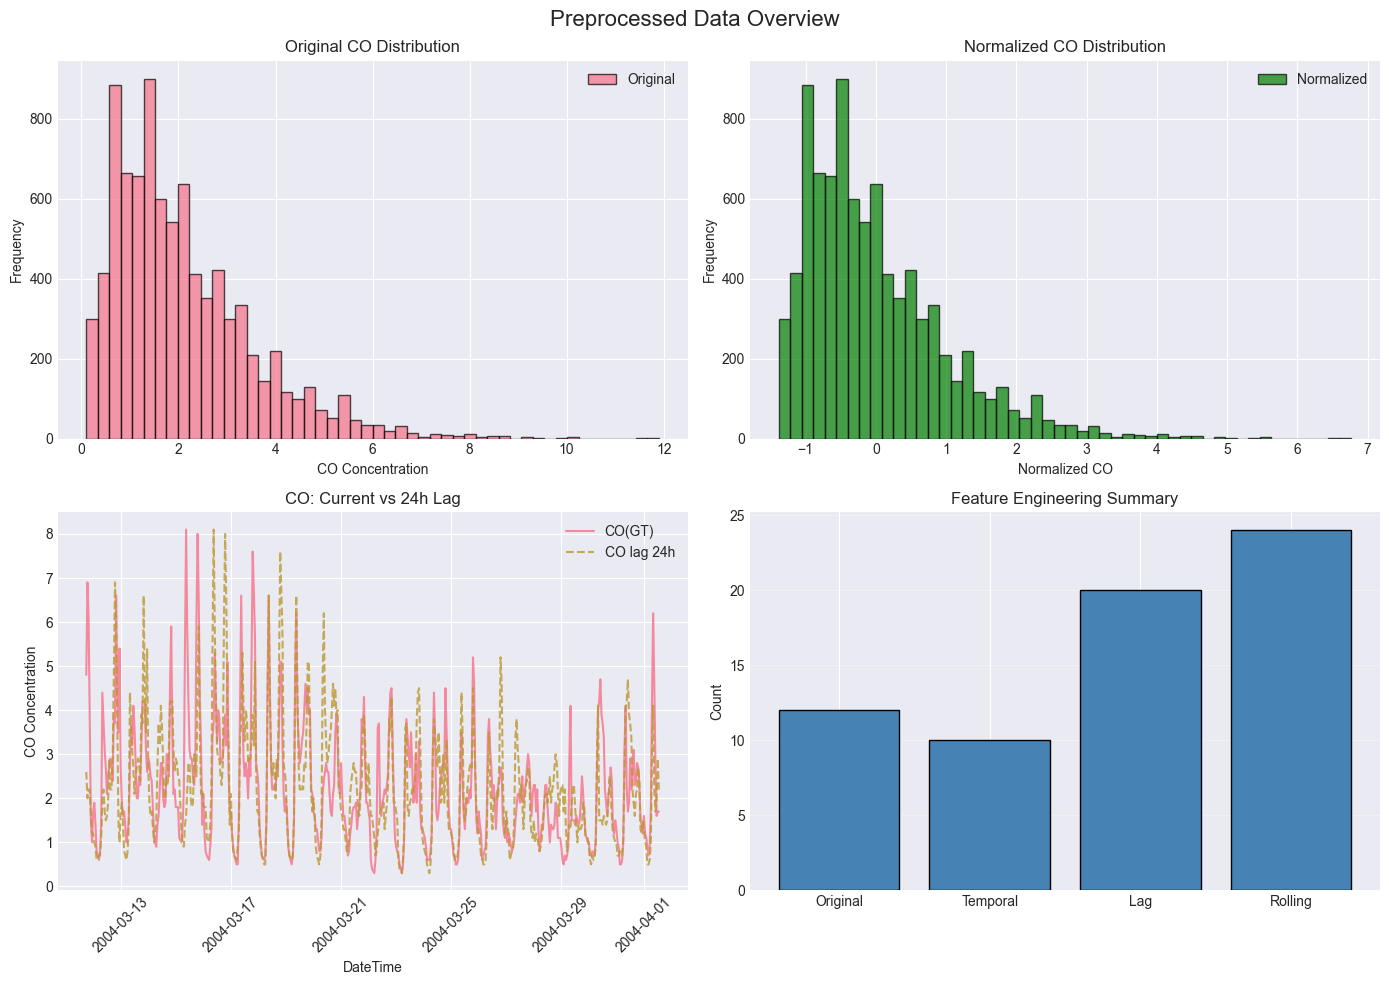

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuration
output_dir = 'preprocessing_output'
os.makedirs(output_dir, exist_ok=True)

print("="*70)
print("DATA PREPROCESSING PIPELINE")
print("="*70)

# ============================================
# 1. LOAD DATA
# ============================================
print("\n[STEP 1] Loading data...")
try:
    df = pd.read_excel('data/air+quality/AirQualityUCI.xlsx')
    print("✓ Loaded from AirQualityUCI.xlsx")
except:
    df = pd.read_csv('data/air+quality/AirQualityUCI.csv', sep=';', decimal=',')
    print("✓ Loaded from AirQualityUCI.csv")

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Merge temporal fields
if df['Date'].dtype == 'object':
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'],
                                     format='%d/%m/%Y %H.%M.%S', errors='coerce')
else:
    df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))

df = df.dropna(subset=['DateTime'])
df = df.set_index('DateTime').sort_index()
df = df.drop(['Date', 'Time'], axis=1)

print(f"  Original shape: {df.shape}")
print(f"  Date range: {df.index.min()} to {df.index.max()}")

# ============================================
# 2. REPLACE SENTINEL VALUES
# ============================================
print("\n[STEP 2] Replacing sentinel value -200 with NaN...")
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    count = (df[col] == -200.0).sum()
    df[col] = df[col].replace(-200.0, np.nan)
    if count > 0:
        print(f"  {col}: {count} values replaced")

# ============================================
# 3. DROP NMHC(GT) - TOO MANY MISSING
# ============================================
print("\n[STEP 3] Dropping NMHC(GT) (90.23% missing)...")
if 'NMHC(GT)' in df.columns:
    df = df.drop('NMHC(GT)', axis=1)
    print("✓ NMHC(GT) removed")

# ============================================
# 4. HANDLE MISSING VALUES
# ============================================
print("\n[STEP 4] Handling missing values...")

pollutants = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
sensors = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
meteo = ['T', 'RH', 'AH']
all_features = pollutants + sensors + meteo

before_missing = df[all_features].isnull().sum().sum()

# Strategy: Linear interpolation (≤6h) -> Forward fill (7-48h) -> Drop (>48h)
for col in all_features:
    # Linear interpolation for short gaps (limit 6 hours)
    df[col] = df[col].interpolate(method='linear', limit=6, limit_direction='both')

    # Forward fill for medium gaps (up to 48 hours)
    df[col] = df[col].fillna(method='ffill', limit=48)

after_interpolation = df[all_features].isnull().sum().sum()
print(f"  Missing before: {before_missing}")
print(f"  Missing after interpolation: {after_interpolation}")
print(f"  Recovered: {before_missing - after_interpolation} values")

# Drop rows with remaining long gaps (>48h)
rows_before = len(df)
df = df.dropna(subset=all_features)
rows_after = len(df)
print(f"  Rows dropped (long gaps): {rows_before - rows_after}")
print(f"✓ Final shape: {df.shape}")

# ============================================
# 5. EXTRACT TEMPORAL FEATURES
# ============================================
print("\n[STEP 5] Creating temporal features...")
df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['Year'] = df.index.year
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
df['DayOfYear'] = df.index.dayofyear

# Cyclical encoding for hour (24h cycle)
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

# Cyclical encoding for month (12 month cycle)
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

print(f"✓ Added temporal features: Hour, DayOfWeek, Month, Year, IsWeekend, etc.")

# ============================================
# 6. CREATE LAG FEATURES
# ============================================
print("\n[STEP 6] Creating lag features...")
lag_hours = [1, 3, 6, 12, 24]

for pollutant in pollutants:
    for lag in lag_hours:
        df[f'{pollutant.split("(")[0]}_lag{lag}h'] = df[pollutant].shift(lag)

print(f"✓ Created {len(pollutants) * len(lag_hours)} lag features")

# ============================================
# 7. CREATE ROLLING STATISTICS
# ============================================
print("\n[STEP 7] Creating rolling window features...")
windows = [6, 12, 24]

for pollutant in pollutants:
    for window in windows:
        # Rolling mean
        df[f'{pollutant.split("(")[0]}_rolling_mean_{window}h'] = \
            df[pollutant].rolling(window=window, min_periods=1).mean()

        # Rolling std
        df[f'{pollutant.split("(")[0]}_rolling_std_{window}h'] = \
            df[pollutant].rolling(window=window, min_periods=1).std()

print(f"✓ Created {len(pollutants) * len(windows) * 2} rolling features")

# ============================================
# 8. DROP ROWS WITH NAN FROM LAG FEATURES
# ============================================
print("\n[STEP 8] Handling NaN from lag/rolling features...")
rows_before = len(df)
df = df.dropna()
rows_after = len(df)
print(f"  Rows dropped: {rows_before - rows_after}")
print(f"✓ Clean shape: {df.shape}")

# ============================================
# 9. NORMALIZE FEATURES
# ============================================
print("\n[STEP 9] Normalizing continuous features...")

# Features to normalize (exclude temporal indicators)
features_to_normalize = (pollutants + sensors + meteo +
                         [col for col in df.columns if 'lag' in col or 'rolling' in col])

scaler = StandardScaler()
df_normalized = df.copy()
df_normalized[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

print(f"✓ Normalized {len(features_to_normalize)} features")

# ============================================
# 10. TEMPORAL SPLIT (2004 train, 2005 test)
# ============================================
print("\n[STEP 10] Creating temporal train/test split...")

train_df = df_normalized[df_normalized['Year'] == 2004]
test_df = df_normalized[df_normalized['Year'] == 2005]

print(f"  Train set (2004): {train_df.shape}")
print(f"  Test set (2005): {test_df.shape}")

# ============================================
# 11. SAVE PREPROCESSED DATA
# ============================================
print("\n[STEP 11] Saving preprocessed data...")

# Save full preprocessed data (unnormalized)
df.to_csv(os.path.join(output_dir, 'preprocessed_data_full.csv'))
print(f"✓ Saved: {output_dir}/preprocessed_data_full.csv")

# Save normalized data
df_normalized.to_csv(os.path.join(output_dir, 'preprocessed_data_normalized.csv'))
print(f"✓ Saved: {output_dir}/preprocessed_data_normalized.csv")

# Save train/test splits
train_df.to_csv(os.path.join(output_dir, 'train_2004.csv'))
test_df.to_csv(os.path.join(output_dir, 'test_2005.csv'))
print(f"✓ Saved: {output_dir}/train_2004.csv")
print(f"✓ Saved: {output_dir}/test_2005.csv")

# Save scaler
import joblib
joblib.dump(scaler, os.path.join(output_dir, 'scaler.pkl'))
print(f"✓ Saved: {output_dir}/scaler.pkl")

# ============================================
# 12. SUMMARY STATISTICS
# ============================================
print("\n" + "="*70)
print("PREPROCESSING SUMMARY")
print("="*70)

print(f"\nFinal dataset:")
print(f"  Total samples: {len(df)}")
print(f"  Total features: {len(df.columns)}")
print(f"  Original features: {len(pollutants + sensors + meteo)}")
print(f"  Temporal features: {len([c for c in df.columns if any(x in c for x in ['Hour', 'Day', 'Month', 'Year', 'Weekend'])])}")
print(f"  Lag features: {len([c for c in df.columns if 'lag' in c])}")
print(f"  Rolling features: {len([c for c in df.columns if 'rolling' in c])}")

print(f"\nTrain/Test split:")
print(f"  Train samples: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Test samples: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

print(f"\nTarget variables (pollutants):")
for pol in pollutants:
    print(f"  {pol}: min={df[pol].min():.2f}, max={df[pol].max():.2f}, mean={df[pol].mean():.2f}")

# ============================================
# 13. VISUALIZATION
# ============================================
print("\n[STEP 12] Creating visualization...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Preprocessed Data Overview', fontsize=16)

# Original vs normalized CO
axes[0, 0].hist(df['CO(GT)'], bins=50, alpha=0.7, label='Original', edgecolor='black')
axes[0, 0].set_xlabel('CO Concentration')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Original CO Distribution')
axes[0, 0].legend()

axes[0, 1].hist(df_normalized['CO(GT)'], bins=50, alpha=0.7,
                label='Normalized', color='green', edgecolor='black')
axes[0, 1].set_xlabel('Normalized CO')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Normalized CO Distribution')
axes[0, 1].legend()

# Time series with lag feature
sample_size = 500
sample_df = df.iloc[:sample_size]
axes[1, 0].plot(sample_df.index, sample_df['CO(GT)'],
                label='CO(GT)', linewidth=1.5, alpha=0.8)
axes[1, 0].plot(sample_df.index, sample_df['CO_lag24h'],
                label='CO lag 24h', linewidth=1.5, alpha=0.8, linestyle='--')
axes[1, 0].set_xlabel('DateTime')
axes[1, 0].set_ylabel('CO Concentration')
axes[1, 0].set_title('CO: Current vs 24h Lag')
axes[1, 0].legend()
axes[1, 0].tick_params(axis='x', rotation=45)

# Feature count by type
feature_types = {
    'Original': len(pollutants + sensors + meteo),
    'Temporal': len([c for c in df.columns if any(x in c for x in ['Hour', 'Day', 'Month', 'Year', 'Weekend'])]),
    'Lag': len([c for c in df.columns if 'lag' in c]),
    'Rolling': len([c for c in df.columns if 'rolling' in c])
}
axes[1, 1].bar(feature_types.keys(), feature_types.values(), color='steelblue', edgecolor='black')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Feature Engineering Summary')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'preprocessing_summary.png'), dpi=300, bbox_inches='tight')
print(f"✓ Saved: {output_dir}/preprocessing_summary.png")

print("\n" + "="*70)
print("PREPROCESSING COMPLETE")
print("="*70)
print(f"\nAll outputs saved to '{output_dir}/' directory")
print("\nNext steps:")
print("  1. Load train_2004.csv for model training")
print("  2. Load test_2005.csv for evaluation")
print("  3. Use scaler.pkl for new data normalization")